# Quora Question Pairs: Modeling
- Hola amigos, this notebook covers my code for the Modeling of **Quora Question Pairs** challenge, which can be found [here](https://www.kaggle.com/c/quora-question-pairs).
- This is the **second notebook**. Check out my [first notebook](https://www.kaggle.com/elemento/quora-questionpairs-eda-visualization), that covers the **EDA & Visualization** aspect of this competition.

# Installing & Importing Packages

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/d/elemento/quora-question-pairs/linear_svm.joblib
/kaggle/input/d/elemento/quora-question-pairs/train_p.txt
/kaggle/input/d/elemento/quora-question-pairs/wordcloud-1.3.3-cp36-cp36m-win_amd64.whl
/kaggle/input/d/elemento/quora-question-pairs/final_features-004.csv
/kaggle/input/d/elemento/quora-question-pairs/nlp_features_train.csv
/kaggle/input/d/elemento/quora-question-pairs/df_fe_without_preprocessing_train.csv
/kaggle/input/d/elemento/quora-question-pairs/final_features_tfidf.csv
/kaggle/input/d/elemento/quora-question-pairs/train_n.txt
/kaggle/input/d/elemento/quora-question-pairs/train-003.db
/kaggle/input/d/elemento/quora-question-pairs/linear_svm_tfidf.joblib
/kaggle/input/d/elemento/quora-question-pairs/final_features.csv
/kaggle/input/d/elemento/quora-question-pairs/xgb_classifier_hpt.joblib
/kaggle/input/d/elemento/quora-question-pairs/final_features_sm.csv
/kaggle/input/d/elemento/quora-question-pairs/logistic_regression.joblib
/kaggle/input/d/elemento/quora-qu

In [2]:
import re
import time
import csv
import math
import sqlite3
import warnings
import numpy as np
import seaborn as sns
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import xgboost as xgb

from joblib import dump, load
from scipy.sparse import hstack
from collections import Counter, defaultdict
from sqlalchemy import create_engine # Database connection
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import accuracy_score, log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, SGDClassifier

warnings.filterwarnings("ignore")

# 4. Machine Learning Models
## 4.1 Reading data from file and storing into sql table

In [3]:
data = pd.read_csv("../input/d/elemento/quora-question-pairs/final_features_sm.csv", nrows = 100000)
print(data.shape)
data.head()

(100000, 221)


,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,15.591466,96.113849,31.001480,-44.172052,21.397091,-46.908810,-100.162247,-1.978221,38.112752,-11.592531
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,-84.838611,54.099417,-65.543286,-23.634332,-85.303453,33.143694,-65.774337,28.145018,-22.243213,0.169092
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,27.926253,33.117176,66.706154,50.397498,42.266215,-29.920099,-53.378103,-31.755547,77.061497,9.438696
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-7.491278,44.788221,6.437781,39.981581,-43.237003,39.471643,-0.322382,-6.074735,-4.417220,5.627428
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,...,44.084751,37.174410,0.356843,-29.468567,33.367771,-12.860933,-44.425541,3.958389,-13.291972,-9.029029


In [4]:
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)
print(data.shape)

(100000, 218)


In [5]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,...,15.591466,96.113849,31.001480,-44.172052,21.397091,-46.908810,-100.162247,-1.978221,38.112752,-11.592531
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,-84.838611,54.099417,-65.543286,-23.634332,-85.303453,33.143694,-65.774337,28.145018,-22.243213,0.169092
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,27.926253,33.117176,66.706154,50.397498,42.266215,-29.920099,-53.378103,-31.755547,77.061497,9.438696
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,...,-7.491278,44.788221,6.437781,39.981581,-43.237003,39.471643,-0.322382,-6.074735,-4.417220,5.627428
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,...,44.084751,37.174410,0.356843,-29.468567,33.367771,-12.860933,-44.425541,3.958389,-13.291972,-9.029029


## 4.2 Random train test split( 70:30)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, y_true, stratify = y_true, test_size = 0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(70000, 218) (30000, 218) (70000,) (30000,)


In [7]:
print("Number of data points in train data:",X_train.shape)
print("Number of data points in test data:",X_test.shape)

Number of data points in train data: (70000, 218)
Number of data points in test data: (30000, 218)


In [8]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274571428571428 Class 1:  0.3725428571428571
---------- Distribution of output variable in train data ----------
Class 0:  0.3725333333333333 Class 1:  0.3725333333333333


In [9]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    """
    This function uses Seaborn Heatmap(s) to plot 3 different matrices. It plots the 
    Confusion Matrix, Precision Matrix and the Recall Matrix. The confusion matrix is as usual.
    In the Precision Matrix, the sum of the values in each column is 1. Similarly, in the
    Recall Matrix, the sum of the values in each row is 1.
    """
    
    C = confusion_matrix(test_y, predict_y)
    # Divide each element of the confusion matrix with the sum of elements in that column
    A = (((C.T)/(C.sum(axis=1))).T)
    # Divide each element of the confusion matrix with the sum of elements in that row
    B = (C/C.sum(axis=0))

    plt.figure(figsize=(12,10))
    
    labels = [0,1]
    cmap=sns.light_palette("blue")
    
    # Representing C in heatmap format
    plt.subplot(2, 2, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    # Representing B in heatmap format
    plt.subplot(2, 2, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    # Representing A in heatmap format
    plt.subplot(2, 2, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## 4.4 Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8841404025689801


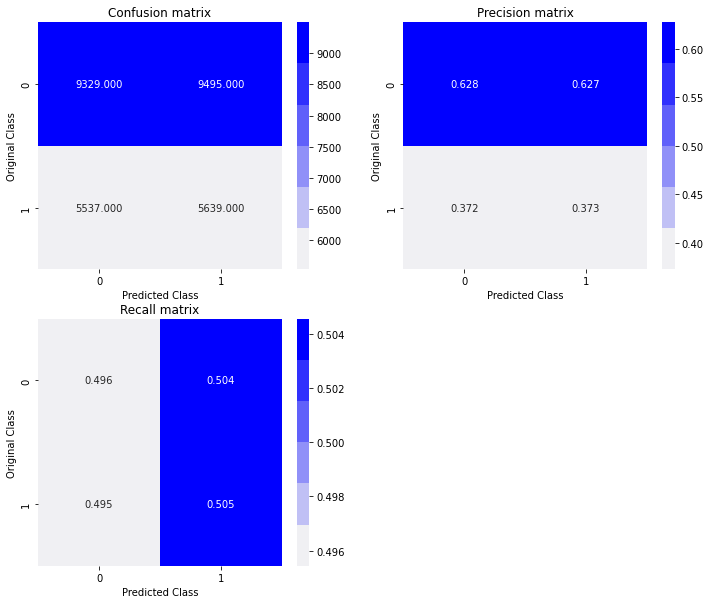

In [10]:
# We need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# We create an output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len, 2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs / sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model", log_loss(y_test, predicted_y, eps=1e-15))

predicted_y = np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## 4.5 Logistic Regression with hyperparameter tuning

In [11]:
# # Hyper-parameters for SGD classifier
# alpha = [10 ** x for x in range(-5, 2)] 

# # Read more about SGDClassifier() at
# # http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

# log_error_array=[]
# for i in alpha:
#     clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
#     clf.fit(X_train, y_train)
#     sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
#     sig_clf.fit(X_train, y_train)
#     predict_y = sig_clf.predict_proba(X_test)
#     log_error_array.append(log_loss(y_test, predict_y, labels = clf.classes_))
#     print('Alpha:', i, "Log loss:", log_loss(y_test, predict_y, labels = clf.classes_))

# fig, ax = plt.subplots()
# ax.plot(alpha, log_error_array,c='g')
# for i, txt in enumerate(np.round(log_error_array, 3)):
#     ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], log_error_array[i]))
# plt.grid()
# plt.title("Cross Validation Error for each alpha")
# plt.xlabel("Alpha(s)")
# plt.ylabel("Error measure")
# plt.show()

# best_alpha = np.argmin(log_error_array)
# clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
# clf.fit(X_train, y_train)
# sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
# sig_clf.fit(X_train, y_train)

In [12]:
# Saving the Model
# dump(sig_clf, 'logistic_regression.joblib')

# Loading the Model
sig_clf = load('../input/d/elemento/quora-question-pairs/logistic_regression.joblib')

Best Alpha: 0.01, Train log loss: 0.44120610102530256
Best Alpha: 0.01, Test log loss: 0.4433159940253536
Total number of data points: 30000


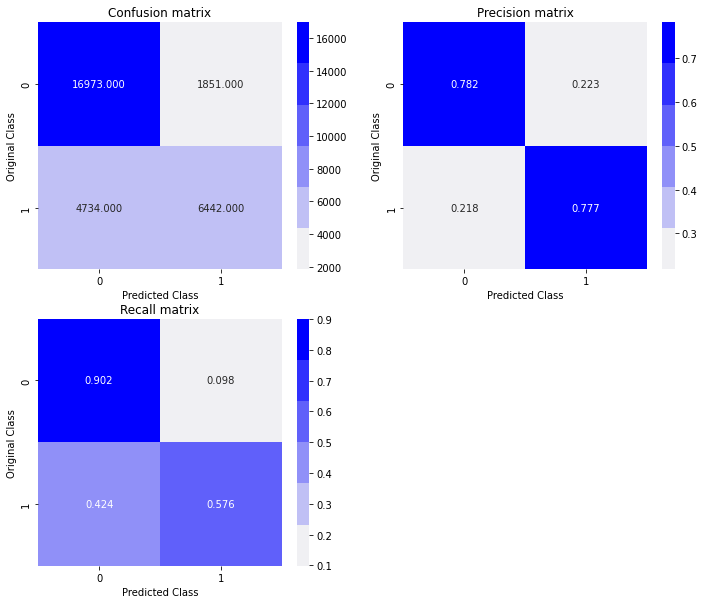

In [13]:
predict_y = sig_clf.predict_proba(X_train)
print("Best Alpha: 0.01, Train log loss:",log_loss(y_train, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_test)
print("Best Alpha: 0.01, Test log loss:",log_loss(y_test, predict_y, labels=sig_clf.classes_))
predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points:", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 4.6 Linear SVM with hyperparameter tuning

In [14]:
# # Hyper-parameters for SGD classifier
# alpha = [10 ** x for x in range(-5, 2)]

# # Read more about SGDClassifier() at
# # http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

# log_error_array=[]
# for i in alpha:
#     clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
#     clf.fit(X_train, y_train)
#     sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
#     sig_clf.fit(X_train, y_train)
#     predict_y = sig_clf.predict_proba(X_test)
#     log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_))
#     print('Alpha:', i, "Log loss:", log_loss(y_test, predict_y, labels = clf.classes_, eps=1e-15))

# fig, ax = plt.subplots()
# ax.plot(alpha, log_error_array,c='g')
# for i, txt in enumerate(np.round(log_error_array,3)):
#     ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
# plt.grid()
# plt.title("Cross Validation Error for each alpha")
# plt.xlabel("Alpha(s)")
# plt.ylabel("Error measure")
# plt.show()

# best_alpha = np.argmin(log_error_array)
# clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
# clf.fit(X_train, y_train)
# sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
# sig_clf.fit(X_train, y_train)

In [15]:
# Saving the Model
# dump(sig_clf, 'linear_svm.joblib')

# Loading the Model
sig_clf = load('../input/d/elemento/quora-question-pairs/linear_svm.joblib')

Best Alpha: 0.01, Train log loss: 0.4760406304410249
Best Alpha: 0.01, Test log loss: 0.4786341697884366
Total number of data points: 30000


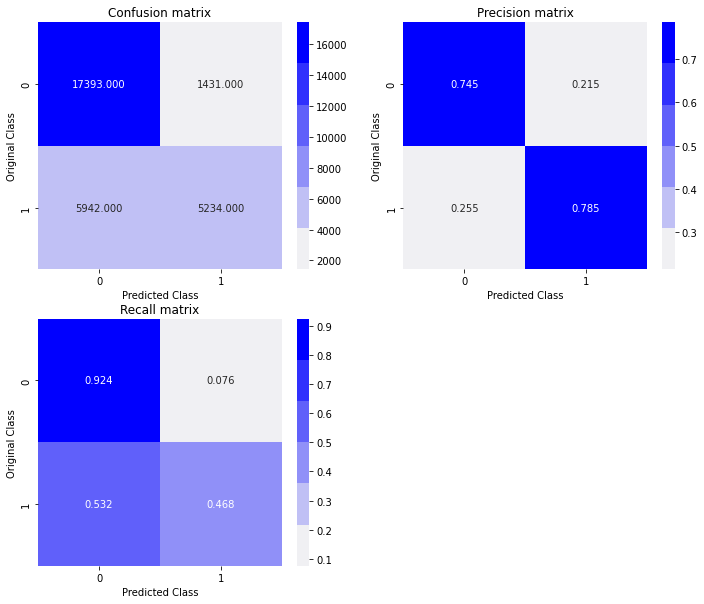

In [16]:
predict_y = sig_clf.predict_proba(X_train)
print("Best Alpha: 0.01, Train log loss:", log_loss(y_train, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_test)
print("Best Alpha: 0.01, Test log loss:", log_loss(y_test, predict_y, labels=sig_clf.classes_))
predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points:", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

- We have a 218-dimensional dataset, which can be considered as neither very high, nor very low. In such cases, we can try both Linear Models as well as more complex models, like GBDT, to make sure that our linear models are not under-fitting.

## 4.7 XGBoost

In [17]:
# params = {}
# params['objective'] = 'binary:logistic'
# params['eval_metric'] = 'logloss'
# params['eta'] = 0.02
# params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label = y_train)
d_test = xgb.DMatrix(X_test, label = y_test)

# watchlist = [(d_train, 'train'), (d_test, 'valid')]
# bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

In [18]:
# Saving the Model
# dump(bst, 'xg_boost.joblib')

# Loading the Model
bst = load('../input/d/elemento/quora-question-pairs/xg_boost.joblib')

Test log loss: 0.3520659654900257
Total number of data points: 30000


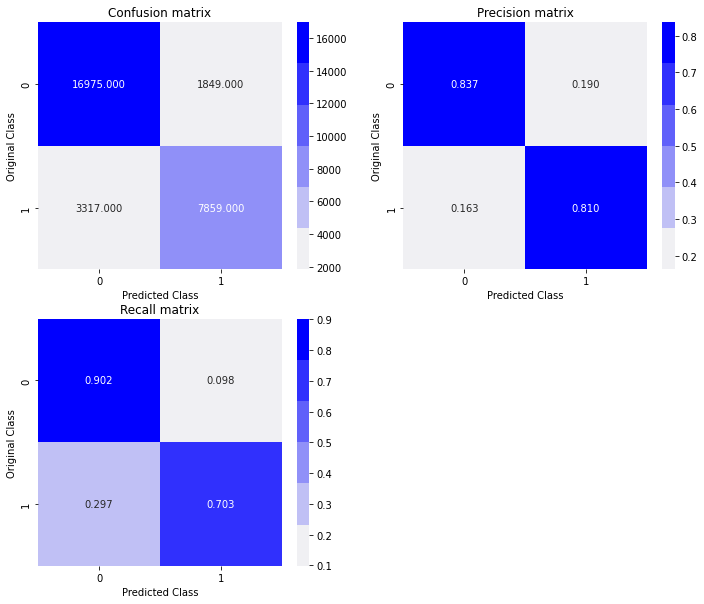

In [19]:
xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("Test log loss:", log_loss(y_test, predict_y, labels = [0, 1]))
predicted_y = np.array(predict_y > 0.5, dtype=int)
print("Total number of data points:", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 5. Modeling Continues
1. Perform hyperparameter tuning  of XgBoost models using RandomsearchCV with vectorizer as TF-IDF W2V  to reduce the log-loss.
2. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.

## 5.1 Hyper-parameter tuning of XGBoost with TF-IDF W2V

In [20]:
# params = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [15, 20, None], 
#     'objective': ['binary:logistic'],
#     'eval_metric': ['logloss'],
# }

# xgbr = xgb.XGBClassifier(verbosity = 1)
# clf = RandomizedSearchCV(xgbr, params)
# clf.fit(X_train, y_train)
# print(clf.best_params_)

In [21]:
# The best hyper-parameters are as follows:
# n_estimators = 150, max_depth = 15, eval_metric = logloss

# Training XGBClassifier with the best hyper-parameters
# xgbr = xgb.XGBClassifier(verbosity = 1, n_estimators = 150, max_depth = 15, 
#     objective = 'binary:logistic', eval_metric = 'logloss')
# xgbr.fit(X_train, y_train)

In [22]:
# Saving the Model
# dump(xgbr, 'xgb_classifier_hpt.joblib')

# Loading the Model
xgbr = load('../input/d/elemento/quora-question-pairs/xgb_classifier_hpt.joblib')

n_estimators: , max_depth: , Train log loss: 0.1314686997311666
n_estimators: , max_depth: , Test log loss: 0.12997857934723875
Total number of data points: 30000


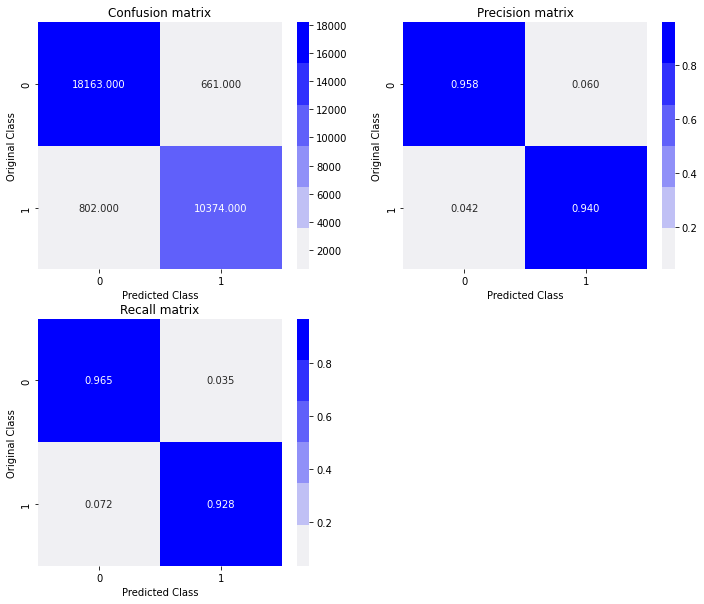

In [23]:
predict_y = xgbr.predict_proba(X_train)
print("n_estimators: , max_depth: , Train log loss:", log_loss(y_train, predict_y, labels=[0,1]))
predict_y = xgbr.predict_proba(X_test)
print("n_estimators: , max_depth: , Test log loss:", log_loss(y_test, predict_y, labels=[0,1]))
predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points:", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## 5.2 Trying out LR, Linear-SVM with TF-IDF

In [24]:
# # Using TF-IDF
# df = pd.read_csv("../input/quora-question-pairs/train.csv.zip")
# df.dropna(axis = 0, subset = ['question1', 'question2'], inplace = True)
# print(df.shape)
# df.head()

In [25]:
# # Merge the Questions
# questions = list(df['question1']) + list(df['question2'])

# tfidf = TfidfVectorizer(min_df = 5, max_features = 500)
# tfidf.fit(questions)

# q1 = tfidf.transform(df['question1'])
# q2 = tfidf.transform(df['question2'])
# print(q1.shape, q2.shape)

In [26]:
# dfnlp = pd.read_csv("../input/d/elemento/quora-question-pairs/nlp_features_train.csv",encoding='latin-1')
# dfppro = pd.read_csv("../input/d/elemento/quora-question-pairs/df_fe_without_preprocessing_train.csv",encoding='latin-1')
# df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
# df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
# df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

# # Creating a DataFrame for the TF-IDF feature vectors
# df3_q1 = pd.DataFrame.sparse.from_spmatrix(q1, index = df3.index)
# df3_q2 = pd.DataFrame.sparse.from_spmatrix(q2, index = df3.index)
# print(df3_q1.shape, df3_q2.shape)

In [27]:
# # Making the Dataset with TF-IDF feature vectors
# df3_q1['id'] = df1['id']
# df3_q2['id'] = df1['id']
# df1  = df1.merge(df2, on='id', how='left')
# df2  = df3_q1.merge(df3_q2, on='id', how='left')
# result  = df1.merge(df2, on='id', how='left')
# result.to_csv('final_features_tfidf.csv')

In [28]:
# Loading the TF-IDF based Dataset
data = pd.read_csv("../input/d/elemento/quora-question-pairs/final_features_tfidf.csv", nrows = 100000)
print(data.shape)
data.head()

(100000, 1029)


,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,490_y,491_y,492_y,493_y,494_y,495_y,496_y,497_y,498_y,499_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,0.0,0.323050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,...,0.0,0.499787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)
print(data.shape)

(100000, 1026)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(data, y_true, stratify = y_true, test_size = 0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(70000, 1026) (30000, 1026) (70000,) (30000,)


### 5.2.1 Logistic Regression

In [31]:
# # Using the hyper-parameters obtained from the previous hyper-parameter tuning
# clf = SGDClassifier(alpha=0.01, penalty='l2', loss='log', random_state=42)
# clf.fit(X_train, y_train)
# sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
# sig_clf.fit(X_train, y_train)

In [32]:
# Saving the Model
# dump(sig_clf, 'logistic_regression_tfidf.joblib')

# Loading the Model
sig_clf = load('../input/d/elemento/quora-question-pairs/logistic_regression_tfidf.joblib')

Best Alpha: 0.01, Train log loss: 0.4337823783404231
Best Alpha: 0.01, Test log loss: 0.43529376875491627
Total number of data points: 30000


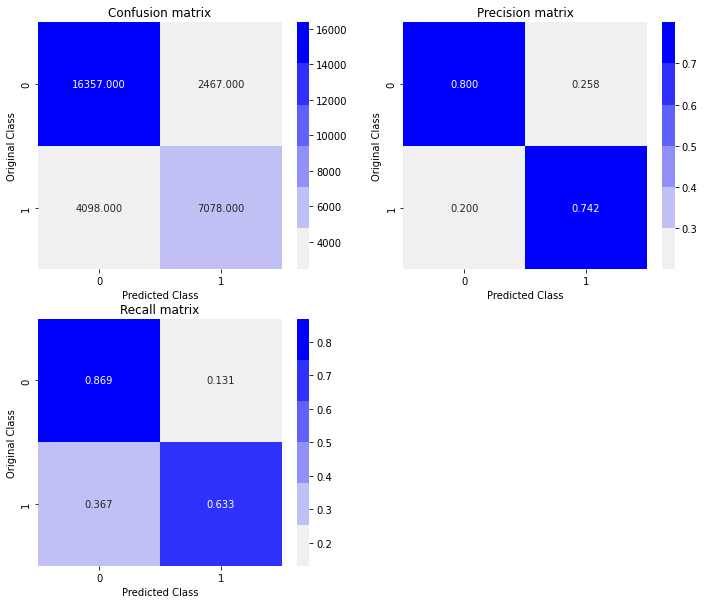

In [33]:
predict_y = sig_clf.predict_proba(X_train)
print("Best Alpha: 0.01, Train log loss:", log_loss(y_train, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_test)
print("Best Alpha: 0.01, Test log loss:", log_loss(y_test, predict_y, labels=sig_clf.classes_))
predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points:", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### 5.2.2 Linear SVM

In [34]:
# # Using the hyper-parameters obtained from the previous hyper-parameter tuning
# clf = SGDClassifier(alpha=0.01, penalty='l2', loss='hinge', random_state=42)
# clf.fit(X_train, y_train)
# sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
# sig_clf.fit(X_train, y_train)

In [35]:
# Saving the Model
# dump(sig_clf, 'linear_svm_tfidf.joblib')

# Loading the Model
sig_clf = load('../input/d/elemento/quora-question-pairs/linear_svm_tfidf.joblib')

Best Alpha: 0.01, Train log loss: 0.43445956669570523
Best Alpha: 0.01, Test log loss: 0.4360127132128606
Total number of data points: 30000


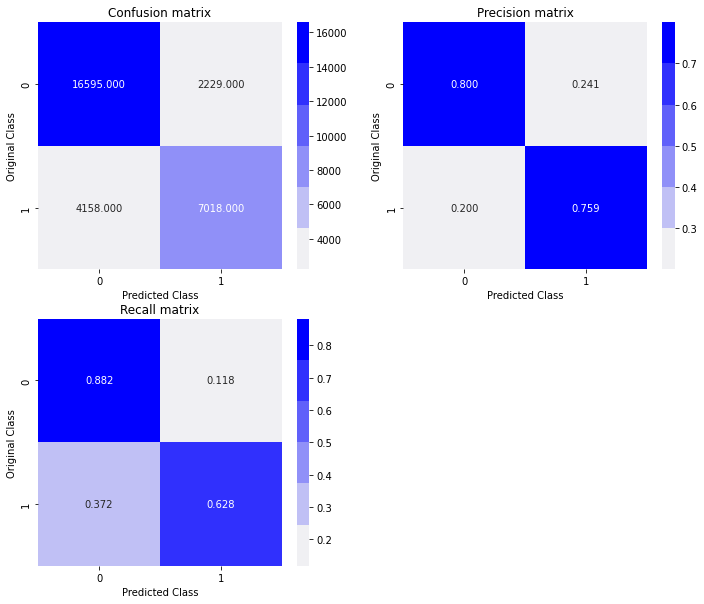

In [36]:
predict_y = sig_clf.predict_proba(X_train)
print("Best Alpha: 0.01, Train log loss:", log_loss(y_train, predict_y, labels=sig_clf.classes_))
predict_y = sig_clf.predict_proba(X_test)
print("Best Alpha: 0.01, Test log loss:", log_loss(y_test, predict_y, labels=sig_clf.classes_))
predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points:", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)